In [1]:
import email.policy
from email.parser import BytesParser
import os
from concurrent.futures import ThreadPoolExecutor
from functools import partial

In [2]:
import sys

sys.path.append("../Handlers")

import preprocessing

[nltk_data] Downloading package punkt to E:/nltk...
[nltk_data]   Package punkt is already up-to-date!


# Testing extracting on a file

In [3]:
paths = [
    "./easy_ham/easy_ham",
    "./hard_ham/hard_ham",
    "./spam_2/spam_2"
]

with open("./spam_2/spam_2/00004.bdcc075fa4beb5157b5dd6cd41d8887b", "rb") as file:
    msg = BytesParser(policy=email.policy.default).parse(file)

print("Receive")
print(msg.get_all("Received"))
print("From")
print(msg.get_all("From"))

Receive
['from mandark.labs.netnoteinc.com ([213.105.180.140]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4GA3qe29480 for    <jm@jmason.org>; Thu, 16 May 2002 11:03:52 +0100', 'from webnote.net (mail.webnote.net [193.120.211.219]) by    mandark.labs.netnoteinc.com (8.11.2/8.11.2) with ESMTP id g4GA3oD28650 for    <jm@netnoteinc.com>; Thu, 16 May 2002 11:03:51 +0100', 'from webcust2.hightowertech.com (webcust2.hightowertech.com    [216.41.166.100]) by webnote.net (8.9.3/8.9.3) with ESMTP id BAA11067 for    <jm@netnoteinc.com>; Thu, 16 May 2002 01:58:00 +0100', 'from html ([199.35.236.73]) by webcust2.hightowertech.com  with    Microsoft SMTPSVC(5.5.1877.197.19); Wed, 15 May 2002 13:50:57 -0700']
From
['jordan23@mailexcite.com']


In [4]:
body = msg.get_body(preferencelist=("html"))

if body:
    payload = body.get_payload(decode=True)
    charset = body.get_content_charset() or "utf-8"
    try:
        extracted_body = payload.decode(charset, errors="replace")
    except:
        extracted_body = payload.decode("utf-8", errors="replace")

from bs4 import BeautifulSoup

clean_text = BeautifulSoup(extracted_body, "html.parser").get_text()
clean_text

'\n\n\n\n\n*****Bonus Fat Absorbers As Seen On TV, Included Free With Purchase Of 2 Or More Bottle, $24.95 Value*****\n\n\n\n***TAKE $10.00 OFF 2 & 3 MONTH SUPPLY ORDERS, $5.00 OFF 1 MONTH SUPPLY!\n***AND STILL GET YOUR BONUS!  PRICE WILL BE DEDUCTED DURING PROCESSING.\n\n\n***FAT ABSORBERS ARE GREAT FOR THOSE WHO WANT TO LOSE WEIGHT,  BUT CAN\'T STAY ON A DIET***\n\n\n***OFFER GOOD UNTIL MAY 27, 2002!  FOREIGN ORDERS INCLUDED!\n\n\n\n\nLOSE 30 POUNDS  IN 30 DAYS... GUARANTEED!!!\n\n\n\nAll Natural Weight-Loss Program, Speeds Up The Metabolism Safely\nRated #1 In Both Categories of SAFETY & EFFECTIVENESS In\n(THE United States Today)\n\nWE\'LL HELP YOU GET THINNER!\nWE\'RE GOING TO HELP YOU LOOK GOOD, FEEL GOOD AND TAKE CONTROL IN\n2002\n\n\n\n\n\n\nWhy Use Our Amazing Weight Loss Capsules?\n\n*  They act like a natural magnet to attract fat.\n*  Stimulates the body\'s natural metabolism. \n*  Controls appetite naturally and makes it easier to\n   eat the right foods consistently.\n*  

# Extract all features from all emails

In [5]:
def extract_spam_assassin_features(file, path):
    if path == "./easy_ham/easy_ham":
        label = 0
    elif path == "./hard_ham/hard_ham":
        label = 0
    elif path == "./spam_2/spam_2":
        label = 1
    else:
        raise ValueError("Path is not included in the function. Please upgrading the function for more paths.")

    with open(file, "rb") as file:
        e = BytesParser(policy=email.policy.default).parse(file)

    part = e.get_body(preferencelist=("plain", "html"))

    if part:
        payload = part.get_payload(decode=True)
        charset = part.get_content_charset()
        try:
            body = payload.decode(charset, errors="replace")
        except:
            body = payload.decode("utf-8", errors="replace")

    else:
        payload = e.get_payload(decode=True)
        body = payload.decode("utf-8", errors="replace") if payload else ""

    body = BeautifulSoup(body, "html.parser").get_text()

    return {
        "Subject": e.get("Subject"),
        "Date": e.get("Date"),
        "From": e.get_all("From"),
        "To": e.get_all("To"),
        "Received": e.get_all("Received"),
        "Content-Type": e.get_content_type(),
        "Body": body,
        "Is_spam": label
    }    

In [6]:
overall_data = []

for p in paths:

    extract_spam = partial(
        extract_spam_assassin_features,
        path=p
    )

    with ThreadPoolExecutor(max_workers=5) as executor:
        data = list(executor.map(extract_spam, [os.path.join(p, path) for path in os.listdir(p)]))

    overall_data.extend(data)

C:\Users\admin\AppData\Local\Temp\ipykernel_27820\3143141288.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  body = BeautifulSoup(body, "html.parser").get_text()
C:\Users\admin\AppData\Local\Temp\ipykernel_27820\3143141288.py:28: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  body = BeautifulSoup(body, "html.parser").get_text()


In [7]:
overall_data[0]

{'Subject': 'Re: New Sequences Window',
 'Date': 'Thu, 22 Aug 2002 18:26:25 +0700',
 'From': ['Robert Elz <kre@munnari.OZ.AU>'],
 'To': ['Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>'],
 'Received': ['from localhost (localhost [127.0.0.1])\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)',
  'from phobos [127.0.0.1]\tby localhost with IMAP (fetchmail-5.9.0)\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)',
  'from listman.example.com (listman.example.com [66.187.233.211]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for    <zzzz-exmh@example.com>; Thu, 22 Aug 2002 12:34:53 +0100',
  'from listman.example.com (localhost.localdomain [127.0.0.1]) by    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002    07:35:02 -0400 (EDT)',
  'from int-mx1.corp.example.com (int-mx1.corp.example.com    [172.16.52.254]) by listman.redhat.com (P

In [16]:
import pandas as pd

df = pd.DataFrame(overall_data)

if not os.path.exists(
    "./SpamAssassin.csv"
):
    df.to_csv("SpamAssassin.csv", index=False)

In [17]:
csv_file = pd.read_csv("./SpamAssassin.csv")

csv_file.head()

,Subject,Date,From,To,Received,Content-Type,Body,Is_spam
0,Re: New Sequences Window,"Thu, 22 Aug 2002 18:26:25 +0700",['Robert Elz <kre@munnari.OZ.AU>'],['Chris Garrigues <cwg-dated-1030377287.06fa6d...,['from localhost (localhost [127.0.0.1])\tby p...,text/plain,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
1,[zzzzteana] RE: Alexander,"Thu, 22 Aug 2002 12:46:18 +0100",['Steve Burt <Steve_Burt@cursor-system.com>'],"['""\'zzzzteana@yahoogroups.com\'"" <zzzzteana@y...",['from localhost (localhost [127.0.0.1])\tby p...,text/plain,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
2,[zzzzteana] Moscow bomber,"Thu, 22 Aug 2002 13:52:38 +0100",['Tim Chapman <timc@2ubh.com>'],['zzzzteana <zzzzteana@yahoogroups.com>'],['from localhost (localhost [127.0.0.1])\tby p...,text/plain,Man Threatens Explosion In Moscow \n\nThursday...,0
3,[IRR] Klez: The Virus That Won't Die,"Thu, 22 Aug 2002 09:15:25 -0400",['Monty Solomon <monty@roscom.com>'],['undisclosed-recipient:;'],['from localhost (localhost [127.0.0.1])\tby p...,text/plain,Klez: The Virus That Won't Die\n \nAlready the...,0
4,Re: Insert signature,"Thu, 22 Aug 2002 23:36:32 +1000",['Tony Nugent <tony@linuxworks.com.au>'],['Exmh Users Mailing List <exmh-users@example....,['from localhost (localhost [127.0.0.1])\tby p...,text/plain,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",0


In [18]:
csv_file["Is_spam"].value_counts()

0    2801
1    1397
Name: Is_spam, dtype: int64

# Testing the patterns

In [11]:
from spam_email_patterns import date_pattern, time_pattern, url_patterns, phone_number_pattern, email_pattern
import re

test_string = csv_file["Body"][0]
print(re.findall(date_pattern, test_string))

print(re.findall(time_pattern, test_string))

print(re.findall(url_patterns, test_string))

print(re.findall(phone_number_pattern, test_string))

print(re.findall(email_pattern, test_string))

['Wed, 21 Aug 2002', '04 Mar', 'Mar 17 14']
['10:54:46', '18:19:03', '18:19:03', '18:19:04', '18:19:04', '18:19:04', '14:55:56']
['https://listman.redhat.com/mailman/listinfo/exmh-workers\n\n']
['1029945287', '4852-4852', '4852-4852', '4852-4852']
['1029945287.4797.TMDA@deepeddy.vircio.com', 'Exmh-workers@redhat.com']


In [12]:
test_string

'    Date:        Wed, 21 Aug 2002 10:54:46 -0500\n    From:        Chris Garrigues \n    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>\n\n\n  | I can\'t reproduce this error.\n\nFor me it is very repeatable... (like every time, without fail).\n\nThis is the debug log of the pick happening ...\n\n18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}\n18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury\n18:19:04 Ftoc_PickMsgs {{1 hit}}\n18:19:04 Marking 1 hits\n18:19:04 tkerror: syntax error in expression "int ...\n\nNote, if I run the pick command by hand ...\n\ndelta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury\n1 hit\n\nThat\'s where the "1 hit" comes from (obviously).  The version of nmh I\'m\nusing is ...\n\ndelta$ pick -version\npick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 ICT 2002

In [13]:
preprocess_test = preprocessing.preprocess_text(csv_file["Body"][0])
print(preprocess_test)

['date', 'date', 'time', '0500', 'chris', 'garrigues', 'messageid', 'email', 'cant', 'reproduce', 'error', 'repeatable', 'like', 'every', 'time', 'without', 'fail', 'debug', 'log', 'pick', 'happening', 'time', 'pickit', 'exec', 'pick', 'inbox', 'list', 'lbrace', 'lbrace', 'subject', 'ftp', 'rbrace', 'rbrace', 'phone_number', 'sequence', 'mercury', 'time', 'exec', 'pick', 'inbox', 'list', 'lbrace', 'lbrace', 'subject', 'ftp', 'rbrace', 'rbrace', 'phone_number', 'sequence', 'mercury', 'time', 'ftocpickmsgs', '1', 'hit', 'time', 'marking', '1', 'hits', 'time', 'tkerror', 'syntax', 'error', 'expression', 'int', 'note', 'run', 'pick', 'command', 'hand', 'delta', 'pick', 'inbox', 'list', 'lbrace', 'lbrace', 'subject', 'ftp', 'rbrace', 'rbrace', 'phone_number', 'sequence', 'mercury', '1', 'hit', 'thats', '1', 'hit', 'comes', 'obviously', 'version', 'nmh', 'im', 'using', 'delta', 'pick', 'version', 'pick', 'nmh104', 'compiled', 'fuchsiacsmuozau', 'sun', 'date', 'time', 'ict', '2002', 'relevant

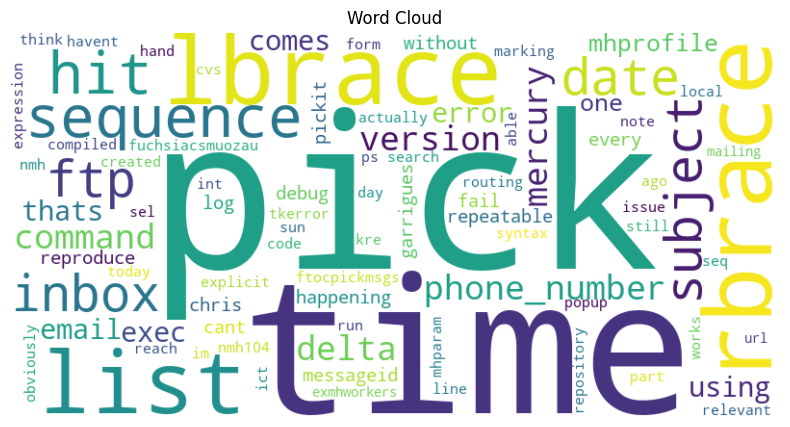

In [14]:
preprocessing.visualize_wordcloud(preprocess_test)

# Preprocess all text

In [20]:
preprocession = partial(
    preprocessing.preprocess_text,
    remove_numbers=True
)

preprocessed_data = csv_file["Body"].apply(preprocession)
preprocessed_data

0       [date, date, time, chris, garrigues, messageid...
1       [martin, posted, tassos, papadopoulos, greek, ...
2       [man, threatens, explosion, moscow, thursday, ...
3       [klez, virus, wont, die, already, prolific, vi...
4       [wed, date, time, ulises, ponce, wrote, hi, co...
                              ...                        
4193    [preferred, nonsmoker, doctor, ordered, case, ...
4194    [dear, subscriber, could, show, way, get, visi...
4195    [midsummer, customer, appreciation, sale, expr...
4196    [attnsirmadan, strictly, confidential, pleased...
4197    [mv, efaeefcdfdcbaphone_numberefaeefcdfdcba, m...
Name: Body, Length: 4198, dtype: object

In [23]:
import itertools

combined = list(itertools.chain.from_iterable(preprocessed_data))
len(combined)

642822

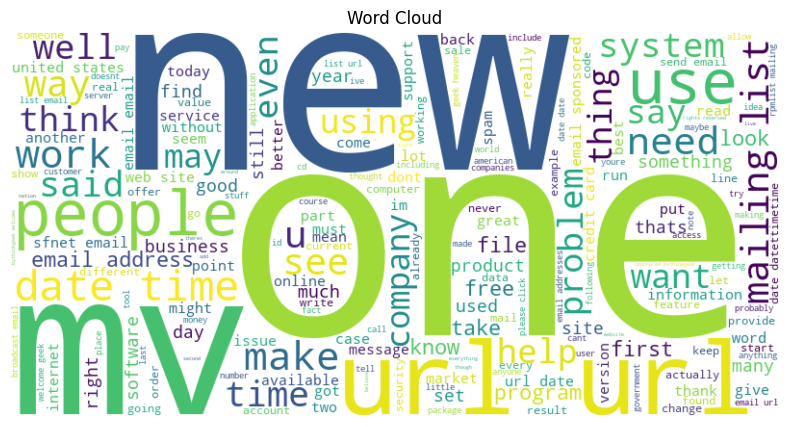

In [24]:
preprocessing.visualize_wordcloud(combined)

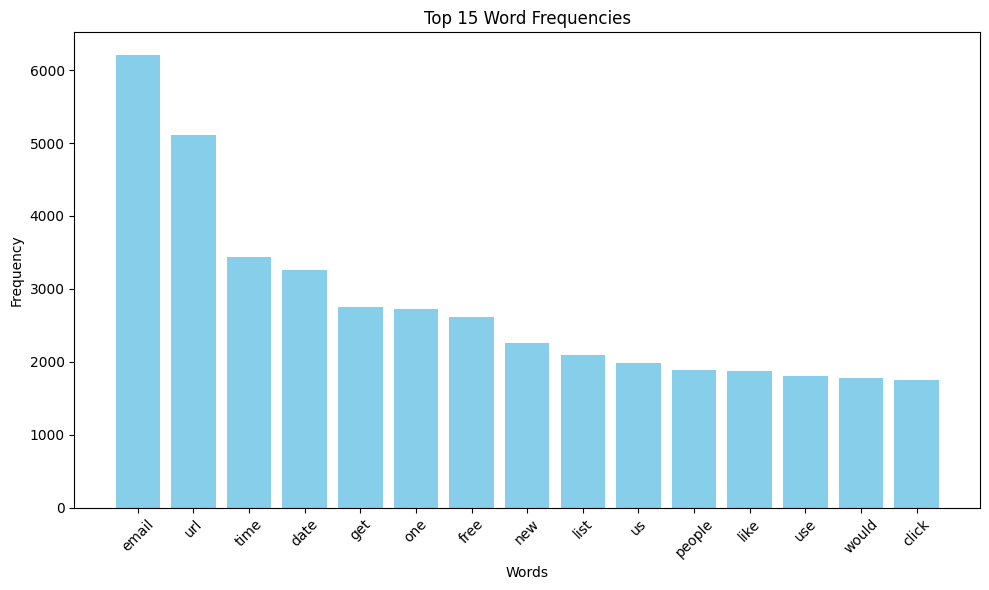

In [27]:
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter(combined)
most_common = counter.most_common(15)

words, counts = zip(*most_common)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title("Top 15 Word Frequencies")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()